# Part 1: Clustering and Dimensionality Reduction

## 1a: Preprocessing

In [1]:
import polars as pl
import pandas as pd 

# Load datasets
demo = pd.read_csv("DemoStats.csv")
spend = pd.read_csv("HouseholdSpend.csv")

# Display basic info
print("DemoStats shape:", demo.shape)
print("HouseholdSpend shape:", spend.shape)
print("\nDemoStats preview:\n", demo.head())
print("\nHouseholdSpend preview:\n", spend.head())

# Check for a shared key column
print("\nCommon columns:", set(demo.columns).intersection(set(spend.columns)))

DemoStats shape: (868970, 736)
HouseholdSpend shape: (868970, 246)

DemoStats preview:
      CODE     GEO  ECYASQKM  ECYALSQKM  ECYBASPOP  ECYBASHHD  ECYBASHPOP  \
0  A0A0A0  FSALDU         0          0          0          0           0   
1  A0A1A0  FSALDU         0          0         55         33          55   
2  A0A1B0  FSALDU         0          0        588        243         588   
3  A0A1C0  FSALDU         0          0       1793        709        1791   
4  A0A1E0  FSALDU         0          0        452        176         449   

   ECYBAS12P  ECYBAS15P  ECYBAS18P  ...  ECYGEN1GEN  ECYGEN2GEN  ECYGEN3GEN  \
0          0          0          0  ...           0           0           0   
1         55         55         55  ...           0           0          55   
2        561        512        475  ...          11          14         563   
3       1548       1465       1405  ...          50          32        1709   
4        415        389        357  ...          10         

In [2]:
# Merge on common columns
data = pd.merge(demo, spend, on=["CODE", "GEO"], how="inner")

# Drop identifier columns
data = data.drop(columns=["CODE", "GEO"])
data.shape

(868970, 978)

Now let's look into columns with null values and deal with them based on what we find.

In [3]:
# Check for non-numerical columns
non_numerical_cols = len(data.select_dtypes(exclude=['number']).columns)
print(f'Found {non_numerical_cols} non-numerical columns.\n')

# Columns with at least one null
null_columns = data.columns[data.isnull().any()]

# Total number of rows
total_rows = len(data)

# Count nulls and percent nulls
null_counts = data[null_columns].isnull().sum()
null_percent = null_counts / total_rows * 100

# Percent of non-null rows that are zero
zero_percent = (data[null_columns] == 0).sum() / data[null_columns].notnull().sum() * 100

# Combine all into one DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Percent Nulls': null_percent,
    'Percent Zeros': zero_percent
})

print(null_summary)

Found 0 non-numerical columns.

           Null Count  Percent Nulls  Percent Zeros
ECYPTAMED       87459      10.064674            0.0
ECYPMAMED       96444      11.098657            0.0
ECYPFAMED      131837      15.171640            0.0
ECYHTAMED       92709      10.668838            0.0
ECYHMAMED      101698      11.703281            0.0
ECYHFAMED      137900      15.869363            0.0
ECYMTNMED       92709      10.668838            0.0


There are seven columns with large amounts of null values, but not large enough to simply drop them right away. Let's decide whether to drop them or not based on whether they show any correlation with the target variable.

In [4]:
# Create target variable
temp_df = pd.DataFrame()
temp_df["target"] = data["HSEP001S"] / data["HSHNIAGG"]

# Compare variables with null values
cols_to_compare = data[['ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED',
                        'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']]

# Calculate correlation with target
correlations = cols_to_compare.corrwith(temp_df['target']).dropna()
correlation_table = correlations.sort_values(key=abs, ascending=False).reset_index()
correlation_table.columns = ['Variable', 'Correlation with Target']

print(correlation_table.to_string(index=False))

 Variable  Correlation with Target
ECYMTNMED                -0.524898
ECYHTAMED                -0.299881
ECYPTAMED                -0.297976
ECYHFAMED                -0.290344
ECYPFAMED                -0.284681
ECYHMAMED                -0.229441
ECYPMAMED                -0.228437


All of the columns with null values seem to have meaningfuly enough correlation with the target such that we should keep them and impute the null values. Let's do that next.

In [5]:
# Creates dict of the column names and the median of the column
dict_median = {column: data[column].median() for column in null_columns}
print(dict_median)

# Replace the NA/NaN values with the median of the column
data.fillna(value=dict_median, inplace=True)

{'ECYPTAMED': 41.3, 'ECYPMAMED': 40.0, 'ECYPFAMED': 42.5, 'ECYHTAMED': 41.1, 'ECYHMAMED': 40.0, 'ECYHFAMED': 42.5, 'ECYMTNMED': 55.0}


Now we will read the metadata files to find any variables related to the target variables, including the target variables themselves and save them for dropping in order to prevent data leakage.

In [6]:
household_meta = pd.read_csv("Documentation/HouseholdSpend 2024 - Metadata.csv")
demostats_meta = pd.read_csv("Documentation/DemoStats 2024 - Metadata.csv")

# Define keywords
keywords = ['insurance', 'pension', 'retirement', 'income tax', 'income', 'RRIF']

# Filter by keyword in description
def find_related_vars(df, desc_col='Description', var_col='Variable'):
    # Match keyword in description
    mask = df[desc_col].str.lower().str.contains('|'.join(keywords), na=False)
    related = df[mask].copy()
    related_vars = related[var_col].unique()

    # Include derived variables by prefix match
    derived_mask = df[var_col].apply(lambda x: any(str(x).startswith(prefix) for prefix in related_vars))
    derived = df[derived_mask]

    # Combine and filter columns
    combined = pd.concat([related, derived]).drop_duplicates()
    return combined[['Variable', 'Description', 'Category', 'Root Formula']]

# Find matching variables
demo_related = find_related_vars(demostats_meta)
spend_related = find_related_vars(household_meta)

# Extract variable names for dropping
drop_vars = list(demo_related['Variable'].unique()) + list(spend_related['Variable'].unique())
drop_vars = [str(var).strip() for var in drop_vars]

print("\nTotal variables marked for dropping:", len(drop_vars))
print("Variable names:\n", drop_vars)



Total variables marked for dropping: 176
Variable names:
 ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P', 'EHYHRIX300', 'EHYHRI300P', 'EHYHRIAVG', 'EHYHRIMED', 'EHYHRIAGG', 'EHYHNI_020', 'EHYHNI2040', 'EHYHNI4060', 'EHYHNI6080', 'EHYHNIX100', 'EHYHNI100P', 'EHYHNIX125', 'EHYHNIX150', 'EHYHNIX200', 'EHYHNI200P', 'EHYHNIX300', 'EHYHNI300P', 'EHYHNIAVG', 'EHYHNIMED', 'EHYHNIAGG', 'ECYHRI_020', 'ECYHRI2040', 'ECYHRI4060', 'ECYHRI6080', 'ECYHRIX100', 'ECYHRI100P', 'ECYHRIX125', 'ECYHRIX150', 'ECYHRIX200', 'ECYHRI200P', 'ECYHRIX300', 'ECYHRI300P', 'ECYHRIAVG', 'ECYHRIMED', 'ECYHRIAGG', 'ECYHNI_020', 'ECYHNI2040', 'ECYHNI4060', 'ECYHNI6080', 'ECYHNIX100', 'ECYHNI100P', 'ECYHNIX125', 'ECYHNIX150', 'ECYHNIX200', 'ECYHNI200P', 'ECYHNIX300', 'ECYHNI300P', 'ECYHNIAVG', 'ECYHNIMED', 'ECYHNIAGG', 'ECYPNIHP15', 'ECYPNININ', 'ECYPNIWIN', 'ECYPNIAVG', 'ECYINDFINA', 'P3YHRI_020', 'P3YHRI2040', 'P3YHRI4060', 'P3

We've found 176 variables that are related to the target variables, many of which are demographic statistics that would allow the target variables to be reverse engineered, at least to some degree. So let's drop these variables, but note that the actual provied data does not actually include all these variables since the metadata file and the actual data are out of sync, as explained by TAs already. Let's just note the ones that we didn't find in the data and then remove the ones that we did find!

In [7]:
found = [col for col in drop_vars if col in data.columns]
missing = [col for col in drop_vars if col not in data.columns]

print(f"\nFound {len(found)} of {len(drop_vars)} drop_vars in the data.")
print("Examples not found:", missing[:10])

before_cols = data.shape[1]
# Drop columns
data = data.drop(columns=[col for col in drop_vars if col in data.columns])
after_cols = data.shape[1]

print(f"\nDropped {before_cols - after_cols} columns from data.")


Found 47 of 176 drop_vars in the data.
Examples not found: ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P']

Dropped 47 columns from data.


Finally, we want to check for outliers in the columns, for each outlier we find outside the IQR range, we will set it to the lower and upper bound of the IQR respectively. We chose IQR here because the z-score clipping method is sensitive to datasets that are very skewed and since we don't know all the details about how skewed and strong the outliers in this dataset are, it's better to be conservative and just use the robust IQR method.

In [8]:
# IQR-based winsorization
for col in data.select_dtypes(include='number').columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower, upper=upper)

print("Outliers have been capped using IQR method (1.5 * IQR).")

Outliers have been capped using IQR method (1.5 * IQR).


Finally, we will remove columns with very low variance (essentially repeated data and noise), and then scale the data.

In [9]:
from sklearn.preprocessing import StandardScaler

# Drop columns with all same values (including all zeros)
low_variance_cols = data.columns[data.nunique() <= 1]
data = data.drop(columns=low_variance_cols)
print(f"Dropped {len(low_variance_cols)} low-variance columns.")

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Output shape of cleaned and scaled data
print("Final cleaned shape:", data_scaled_df.shape)

Dropped 304 low-variance columns.
Final cleaned shape: (868970, 627)


## 1b K-Means Clustering

Since the dataset is so large, and our machines are not so powerful in comparison, we can use the elbow and silhouette methods on a sample of the data to get an idea of what the number of clusters should be. Based on that we can run one (or just much fewer) KMeans on the full dataset.

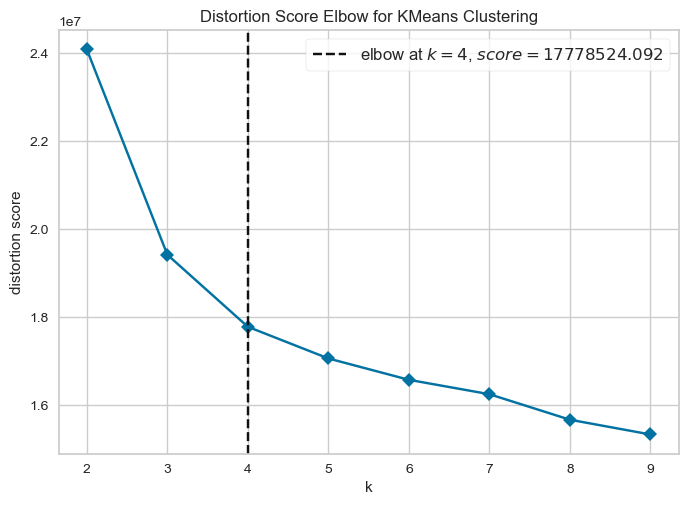

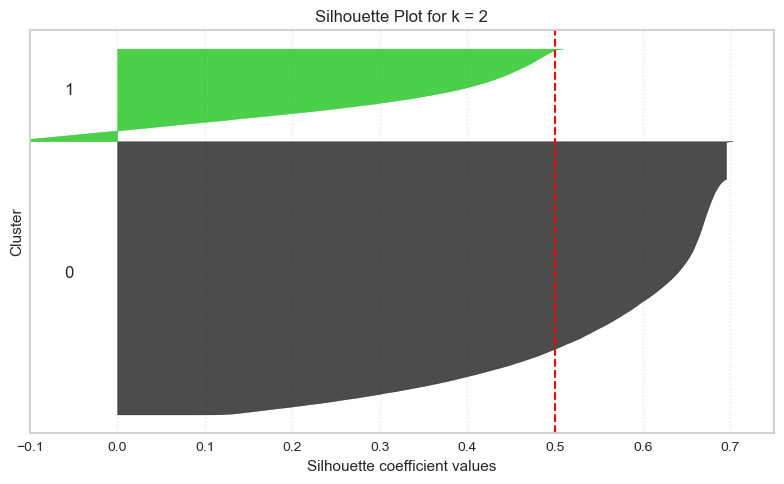

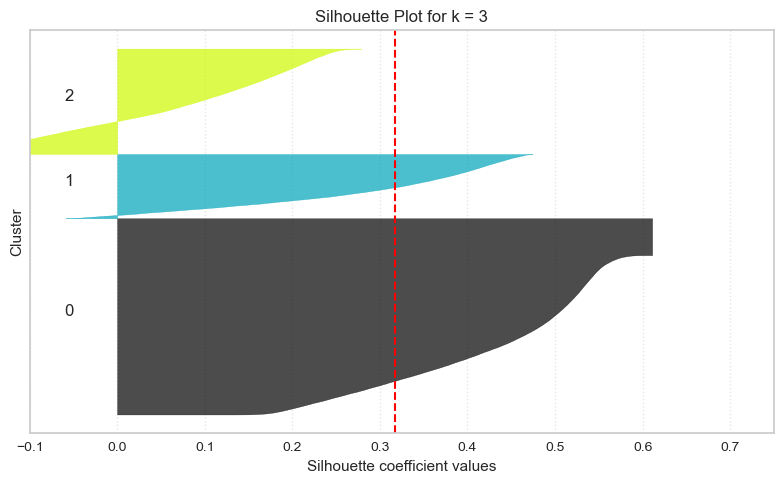

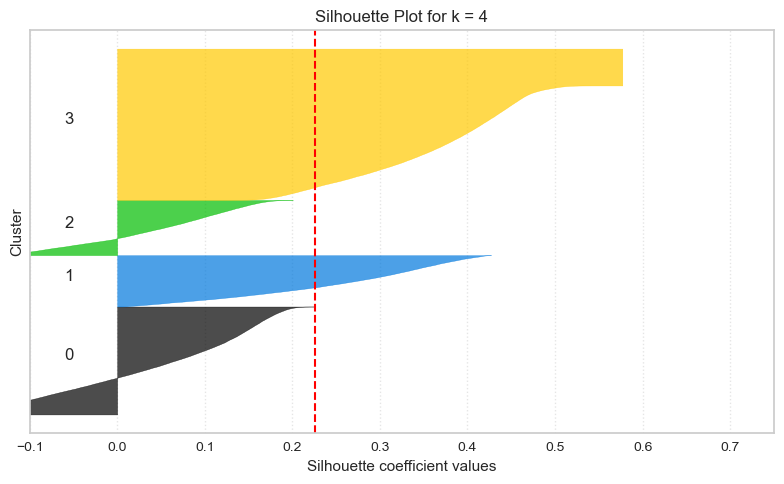

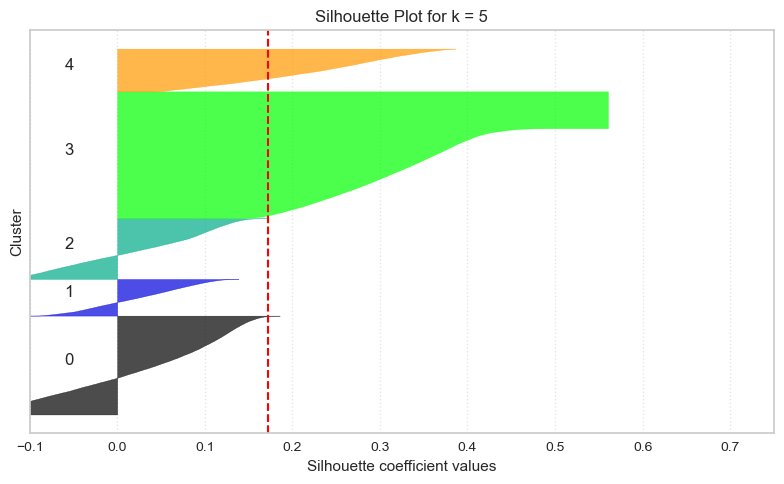

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer

os.makedirs("figures", exist_ok=True)
plt.rcParams.update({'font.size': 12})

# Sample the data
sample_size = 80000
rng = np.random.default_rng(seed=42)
sample_idx = rng.choice(data_scaled_df.shape[0], size=sample_size, replace=False)
sample = data_scaled_df.iloc[sample_idx]

# Elbow Method
model = KMeans(random_state=42, n_init='auto')
visualizer = KElbowVisualizer(model, k=(2, 10), locate_elbow=True, timings=False)
visualizer.fit(sample)
visualizer.show(outpath="figures/elbow_plot.png")
optimal_k = visualizer.elbow_value_

# Silhouette plots for k = 2 to 5
range_n_clusters = list(range(2, 6))
silhouette_scores = []

for k in range_n_clusters:
    fig, ax = plt.subplots(figsize=(8, 5))

    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(sample)

    silhouette_avg = silhouette_score(sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(sample, cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_vals = sample_silhouette_values[cluster_labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.06, y_lower + 0.5 * size_i, str(i))

        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(f"Silhouette Plot for k = {k}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster")
    ax.set_yticks([])
    ax.set_xlim([-0.1, 0.75])
    ax.grid(True, axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()

    plt.savefig(f"figures/silhouette_k{k}.png")
    plt.show()

# Silhouette Score Line Plot
plt.figure(figsize=(6, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange', linewidth=2)
plt.title("Average Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig("figures/silhouette_scores.png")
plt.close()

The Elbow method and the Silhouette scores are essentially in complete agreement about the optimal number of clusters.  Both seem to indicate some clustering at n=2 clusters, but there is also a strong case to be made for n=3 by them both. The truth is that they don't seem to indicate a perfectly optimal number, and based on the silhouette plots we can see that even at n=2 or n=3, the data isn't well clustered, perhaps suggesting that this dataset doesn't have very many or meaningful "low-density zones" which are a requirement for clustering methods such as K-Means. We'll go ahead and apply K-Means using n=3 and save the results for now so we can colour the PCA plots later using the respective cluster labels.

In [11]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_3 = kmeans_3.fit_predict(data_scaled_df)

clustered_df = pd.DataFrame(data_scaled_df, columns=[f"var_{i}" for i in range(data_scaled_df.shape[1])])
clustered_df["cluster_3"] = labels_3

## 1c Dimensionality Reduction

We'll start by applying PCA over the data and overlaying the clustering labels on the results using colours to see if there are clear clusters in the data. Sometimes, scaling the data can cause dimensionality reduction results to be warped because scaling can distort the relationships between features that naturally have different magnitudes, so it's important to try both scaled and unscaled versions to see which preserves structure better.

In [12]:
from sklearn.decomposition import PCA

# PCA on unscaled data
pca_unscaled = PCA(n_components=3)
pca_data_unscaled = pca_unscaled.fit_transform(data)

# PCA on scaled data
pca_scaled = PCA(n_components=3)
pca_data_scaled = pca_scaled.fit_transform(data_scaled_df)

Explained variance ratio (unscaled): [0.98781339 0.00837158 0.00142905]
Explained variance ratio (scaled): [0.67922796 0.03655754 0.03006363]


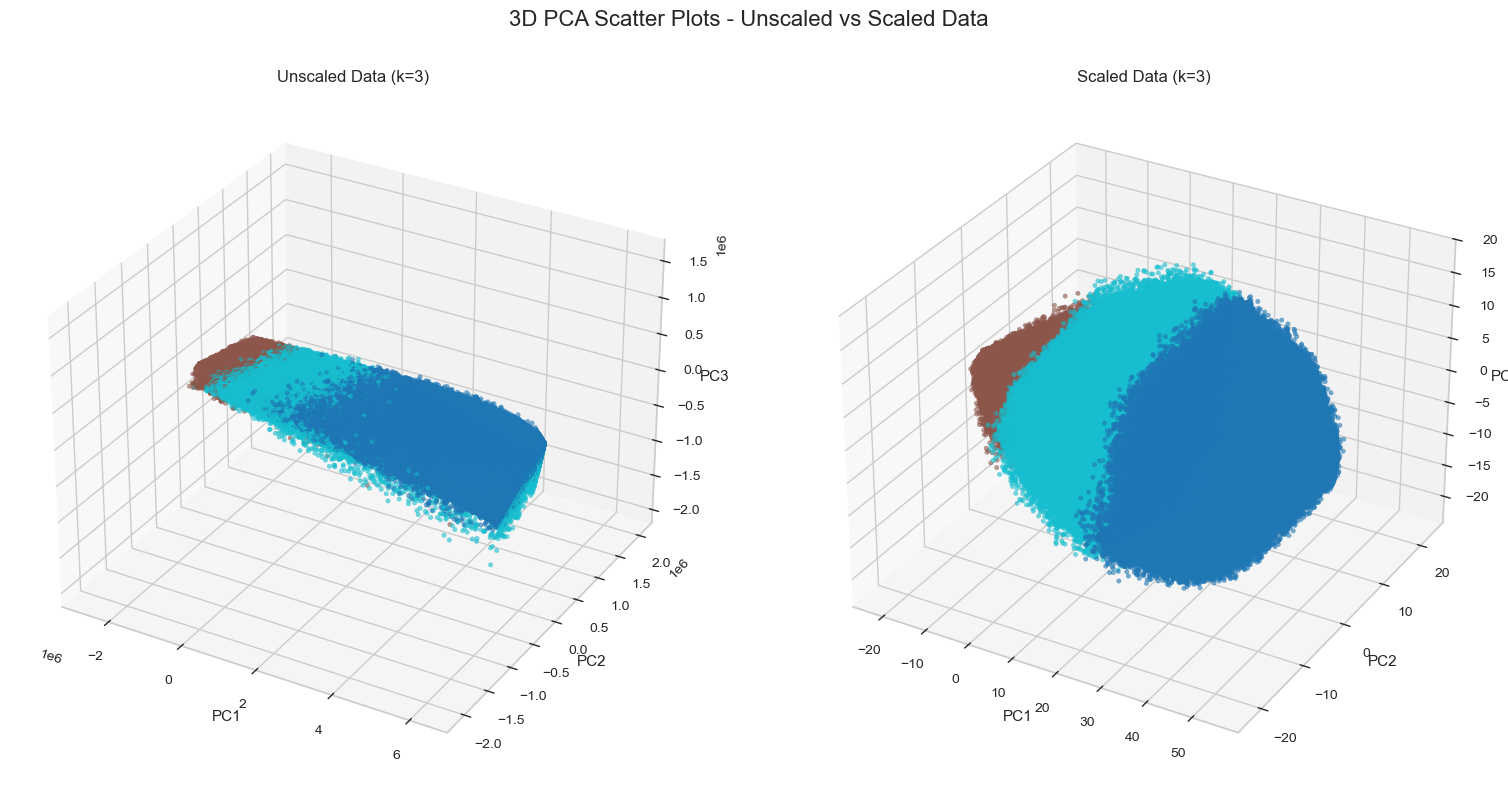

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Print explained variance ratios
print("Explained variance ratio (unscaled):", pca_unscaled.explained_variance_ratio_)
print("Explained variance ratio (scaled):", pca_scaled.explained_variance_ratio_)

# Create figure with 3D subplots
fig = plt.figure(figsize=(16, 8))
fig.suptitle("3D PCA Scatter Plots - Unscaled vs Scaled Data", fontsize=16)

# Unscaled plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(
    pca_data_unscaled[:, 0],
    pca_data_unscaled[:, 1],
    pca_data_unscaled[:, 2],
    c=labels_3,
    cmap='tab10',
    s=10,
    alpha=0.6
)
ax1.set_title("Unscaled Data (k=3)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# Scaled plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(
    pca_data_scaled[:, 0],
    pca_data_scaled[:, 1],
    pca_data_scaled[:, 2],
    c=labels_3,
    cmap='tab10',
    s=10,
    alpha=0.6
)
ax2.set_title("Scaled Data (k=3)")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Interestingly, the PCA applied on the unscaled data seems to have had better results given that PCA1 (unscaled) explains 98.8% of the variance in the data, whereas PCA1 (scaled) explains 67.9% of the data. Even though in the unscaled PCA, PC1 has a very large explained variance, this is most likely because the unscaled data has numbers measured in a larger units and this is interpreted as variance. Therefore, we'll use the scaled data for the PCA moving forward.

Looking at the clustering colours plotted over the PCA results reinforces what we saw in the silhouette plots and the elbow method graph: the data has *some* clustering tendency in the sense that there are weakly clustered regions containing broad gradients, but there is some mixing between these regions suggesting that the data is weakly clustered.

Next let's look more closely at which variables are contributing to the first principal component since it explains 67.9% of the variance, and to what degree. We'll note the description and the category of the variables so we can better understand what each variable represents.

In [14]:
# Loadings for first 3 PCs
pca_loadings = pd.DataFrame(
    pca_scaled.components_[:3].T,
    columns=["PC1", "PC2", "PC3"],
    index=data.columns
).reset_index().rename(columns={"index": "Variable"})

# Merge with metadata
pca_loadings = pca_loadings.merge(
    household_meta[["Variable", "Description", "Variable Type"]].rename(
        columns={
            "Description": "HouseholdSpend Description",
            "Variable Type": "HouseholdSpend Type"
        }
    ),
    on="Variable", how="left"
).merge(
    demostats_meta[["Variable", "Category"]].rename(columns={"Category": "DemoStats Category"}),
    on="Variable", how="left"
)

# Function to get top +/- contributors for a specific PC
def get_formatted_table(pc_name, top_n=5):
    top_pos = pca_loadings.sort_values(pc_name, ascending=False).head(top_n).copy()
    top_pos["Contribution"] = "Top +"
    top_neg = pca_loadings.sort_values(pc_name, ascending=True).head(top_n).copy()
    top_neg["Contribution"] = "Top -"
    df = pd.concat([top_pos, top_neg])
    df["Component"] = pc_name
    df[pc_name] = df[pc_name].apply(lambda x: f"{x:.7f}")
    return df[
        ["Component", "Contribution", "Variable", 
         "HouseholdSpend Description", "HouseholdSpend Type", 
         "DemoStats Category", pc_name]
    ].rename(columns={pc_name: "Loading"})

for pc in ["PC1", "PC2", "PC3"]:
    print(f"\nTop contributors to {pc}:")
    display(get_formatted_table(pc))


Top contributors to PC1:


,Component,Contribution,Variable,HouseholdSpend Description,HouseholdSpend Type,DemoStats Category,Loading
341,PC1,Top +,ECYHOMSING,NaN,NaN,Household Population by Language Spoken Most O...,0.0479052
332,PC1,Top +,ECYMOTSING,NaN,NaN,Household Population by Mother Tongue,0.0478908
213,PC1,Top +,ECYMOBHPOP,NaN,NaN,Household Population by 5-Year Mobility,0.0478890
323,PC1,Top +,ECYAIDHPOP,NaN,NaN,Household Population by Indigenous Identity,0.0478819
363,PC1,Top +,ECYRIMHPOP,NaN,NaN,Household Population by Recent Immigrants (201...,0.0478819
147,PC1,Top -,ECYMTNMED,NaN,NaN,Households by Maintainer Age,-0.0043700
77,PC1,Top -,ECYPFAMED,NaN,NaN,Female Population by Age,-0.0041342
138,PC1,Top -,ECYHFAMED,NaN,NaN,Female Household Population by Age,-0.0034833
57,PC1,Top -,ECYPMAMED,NaN,NaN,Male Population by Age,-0.0034812
118,PC1,Top -,ECYHMAMED,NaN,NaN,Male Household Population by Age,-0.0028164



Top contributors to PC2:


,Component,Contribution,Variable,HouseholdSpend Description,HouseholdSpend Type,DemoStats Category,Loading
477,PC2,Top +,HSSH037A,Wood and other fuel for heating and cooking fo...,Consumption,NaN,0.1151800
98,PC2,Top +,ECYHTAMED,NaN,NaN,Total Household Population by Age,0.1150496
37,PC2,Top +,ECYPTAMED,NaN,NaN,Total Population by Age,0.1124233
118,PC2,Top +,ECYHMAMED,NaN,NaN,Male Household Population by Age,0.1044411
469,PC2,Top +,HSSH034,Other fuel,Consumption,NaN,0.1025401
394,PC2,Top -,ECYNCA_18P,NaN,NaN,Household Population by Citizenship,-0.0945659
318,PC2,Top -,ECYVISVM,NaN,NaN,Household Population by Visible Minority Status,-0.0931506
344,PC2,Top -,ECYHOMNOFF,NaN,NaN,Household Population by Language Spoken Most O...,-0.0912983
392,PC2,Top -,ECYNCANCIT,NaN,NaN,Household Population by Citizenship,-0.0907590
372,PC2,Top -,ECYPIM1621,NaN,NaN,Household Population by Period of Immigration,-0.0874335



Top contributors to PC3:


,Component,Contribution,Variable,HouseholdSpend Description,HouseholdSpend Type,DemoStats Category,Loading
417,PC3,Top +,HSWH040S,Net purchase price of owned residences,Consumption,NaN,0.1316419
414,PC3,Top +,HSTE001ZBS,Total non-current consumption,Consumption,NaN,0.1202014
467,PC3,Top +,HSSH033A,Natural gas charges for owned principal residence,Consumption,NaN,0.1143588
466,PC3,Top +,HSSH033,Natural gas,Consumption,NaN,0.1083685
212,PC3,Top +,ECYCHAHHCH,NaN,NaN,Total Children At Home by Age,0.1031878
232,PC3,Top -,ECYSTYAPU5,NaN,NaN,Occupied Private Dwellings by Structure Type,-0.1307404
334,PC3,Top -,ECYMOTFREN,NaN,NaN,Household Population by Mother Tongue,-0.1283827
231,PC3,Top -,ECYSTYAPT,NaN,NaN,Occupied Private Dwellings by Structure Type,-0.1251468
343,PC3,Top -,ECYHOMFREN,NaN,NaN,Household Population by Language Spoken Most O...,-0.1231447
196,PC3,Top -,ECYHFSCL,NaN,NaN,Census Family Households by Family Structure,-0.1223918


There are many (100s) of variables that contribute meaningfully to each principcal component, so we'll group them by the category they belong to, and plot which categories contribute the most to each principal component to better interpret them.

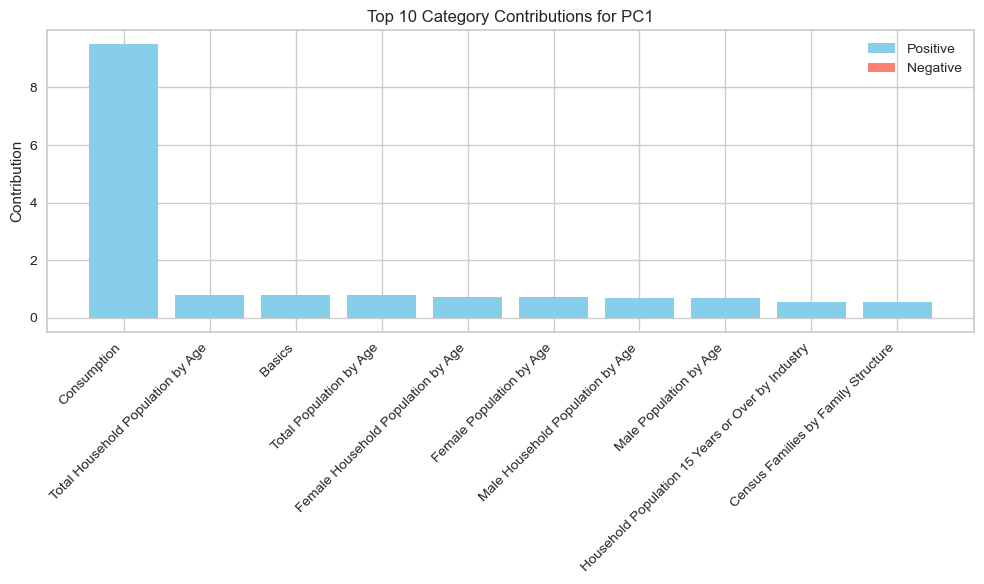

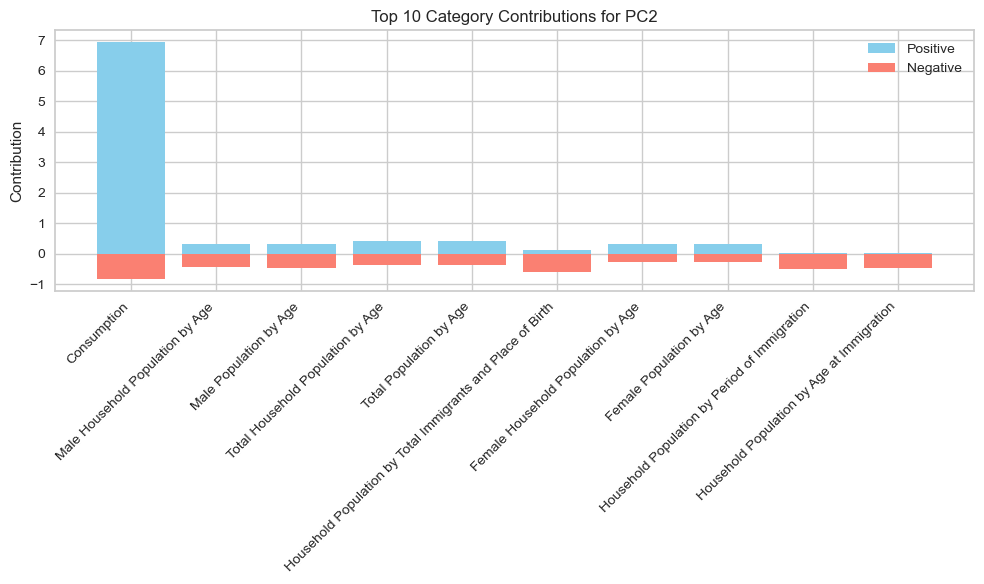

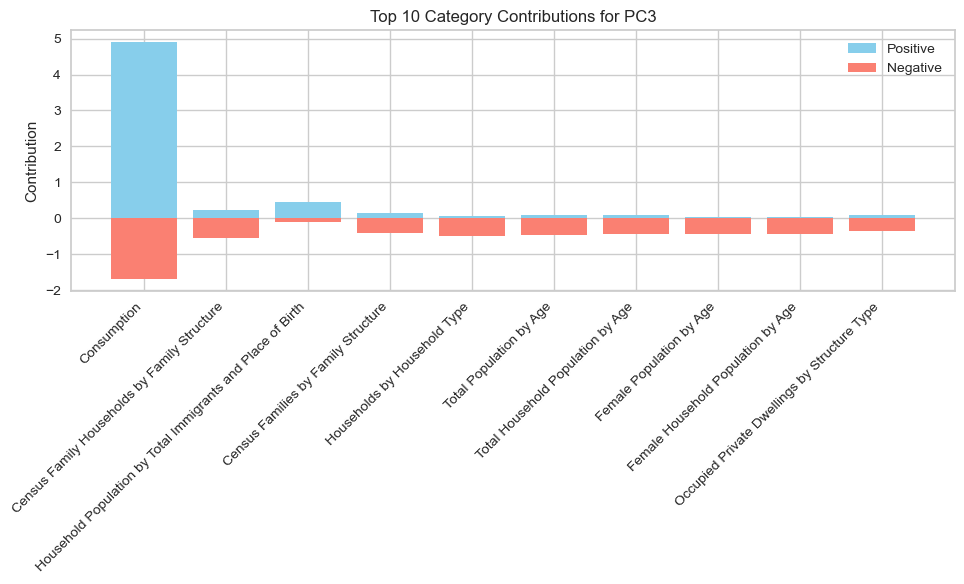

In [15]:
# Create a unified category column with fallback logic
pca_loadings["Unified Category"] = pca_loadings["DemoStats Category"].fillna(pca_loadings["HouseholdSpend Type"])

# Melt the dataframe
melted = pca_loadings.melt(
    id_vars=["Unified Category"],
    value_vars=["PC1", "PC2", "PC3"],
    var_name="Component",
    value_name="Contribution"
)

# Compute positive, negative, and absolute values
melted["Positive"] = melted["Contribution"].clip(lower=0)
melted["Negative"] = melted["Contribution"].clip(upper=0)
melted["Absolute"] = melted["Contribution"].abs()

# Group by component and category
grouped = melted.groupby(["Component", "Unified Category"]).agg({
    "Positive": "sum",
    "Negative": "sum",
    "Absolute": "sum"
}).reset_index()

# Plot top 10 contributors for each component
for pc in ["PC1", "PC2", "PC3"]:
    top10 = grouped[grouped["Component"] == pc].nlargest(10, "Absolute").copy()
    categories = top10["Unified Category"]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(categories, top10["Positive"], label="Positive", color="skyblue")
    ax.bar(categories, top10["Negative"], label="Negative", color="salmon")

    ax.set_title(f"Top 10 Category Contributions for {pc}")
    ax.set_ylabel("Contribution")
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()

#### Interpreting the PCA Results

**PC1: Economic Activity and Household Presence**
The first principal component appears to capture a latent dimension related to economic activity and household engagement in consumption. The dominant positive contribution from the Consumption category suggests that areas with high PC1 scores are characterized by high household spending across various goods and services. Supporting this, substantial positive contributions from population-related categories, particularly Total Household Population by Age and similar breakdowns, indicate that these high-spending areas also tend to have larger and more demographically diverse household populations. There is also a positive contribution from Household Population 15 Years or Over by Industry, which refers to individuals aged 15+ categorized by their employment industry. High values in this category likely point to areas with more economically active residents, further reinforcing the interpretation of PC1 as a general index of economic activity and consumer presence.

**PC2: Immigrant Presence vs. Established Native Households**
PC2 appears to reflect a contrast between areas with higher immigrant presence and those with more established or native-born household populations. Although Consumption still contributes positively, it plays a smaller role than in PC1. Interestingly, several population-related categories contribute in both positive and negative directions, suggesting variation in population composition (e.g., by gender or age) across different areas, rather than a single unified trend. The strongest negative contributions come from immigration-related variables such as Household Population by Total Immigrants and Place of Birth, Period of Immigration, and Age at Immigration. High values in these variables indicate recent and/or large immigrant populations, whereas low values suggest more long-established or non-immigrant populations. Therefore, areas scoring high on PC2 likely have smaller or more established household populations with higher consumer activity, while those scoring low may be areas with larger proportions of recent immigrants.

**PC3: Household Composition and Structural Living Differences**
PC3 seems to capture a latent dimension related to household composition and structural living arrangements. Unlike PC1 and PC2, Consumption has a more muted, and even slightly negative contribution here, suggesting that this component isn't primarily driven by spending behavior. Instead, negative contributions from categories like Total Household Population by Age, Female Household Population by Age, and Census Family Households by Family Structure indicate a shift toward areas with fewer or smaller households and possibly less traditional family structures. High values for family structure-related variables typically reflect a greater presence of multi-person households, couples with children, and other traditional family arrangements — so their negative loadings imply that low-scoring areas on PC3 may be characterized by more non-traditional or single-person households. The additional negative contribution from Occupied Private Dwellings by Structure Type (e.g., types like apartments vs. single-family homes) supports this interpretation, suggesting differences in housing forms may also play a role.

In [16]:
pca_df = pd.DataFrame(pca_data_scaled, columns=["PC1", "PC2", "PC3"])
pca_df["cluster_3"] = labels_3

mean_pcs_k3 = pca_df.groupby("cluster_3")[["PC1", "PC2", "PC3"]].mean()
print("\nMean PC values per cluster (k=3):")
print(mean_pcs_k3)


Mean PC values per cluster (k=3):
                 PC1       PC2       PC3
cluster_3                               
0          37.886854 -0.630043  0.187230
1         -15.129507 -0.217523 -0.000209
2           5.189265  0.795026 -0.114426


#### Interpreting the Clusters
Here we will put the greatest weight on each cluster's PC1 mean, and lesser on PC2 and PC3 means since the latter two only explain 3% of the variance. 

**Cluster 0: Affluent, Traditional Immigrant Families**

Very high on PC1 and moderately negative on PC2, this cluster represents areas with strong consumer activity, large and diverse household populations, and a modest-to-high immigrant presence. The mildly positive PC3 suggests more traditional household and family structures, although there may be some younger families with smaller household populations here.


**Cluster 1: Low-Spending, High-Immigration Small Households**

With the lowest PC1 score and near-zero values for PC2 and PC3, this cluster reflects areas with low consumer activity and household population. Its negative PC2 means the cluster likely includes a higher concentration of immigrant households, and the slightly negative PC3 suggests smaller household populations, so these may be single-person, young immigrant households with minimal spending capacity.

**Cluster 2: Mid-Spending, Native, Non-Traditional Households**

A moderate PC1 shows average economic activity, while the strongly positive PC2 reflects a low immigrant presence. The slightly negative PC3 suggests more non-traditional household types, such as single-person or younger professional households, and possibly denser or more urban housing. These may be urban or suburban, Canadian-born neighborhoods with moderate spending and a prevalence of non-family or young adult / young professional living arrangements.

## 1d UMAP

We will use UMAP as another dimensionality reduction method to visualize the clusters.

In [23]:
import umap.umap_ as umap
import seaborn as sns

# Function to run UMAP
def run_umap(data2, n_neighbors=40, min_dist=1, spread=1.5, metric='euclidean', n_epochs=100, verbose=False):
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                        n_components=2,
                        metric=metric,
                        random_state=42,
                        min_dist=min_dist,
                        spread=spread,
                        low_memory=False,
                        n_epochs=n_epochs,
                        verbose=verbose,
                        n_jobs=-1)
    return reducer.fit_transform(data2)

# Draw the UMAP plot
def plot_umap(embedding, labels, title):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels)
    plt.title(title)
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.show()

# Plot UMAP in subplots
def plot_umap_subplot(embedding, labels, title, ax):
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, ax=ax, legend=False, s=10)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Component 1", fontsize=8)
    ax.set_ylabel("Component 2", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)


We will run UMAP with a few different hyperparameters to see how they affect the results and for now we will use 100 epochs, but we will increase it later for the final run. We will also try different metrics to see which one works the best.

In [ ]:
# Different hyperparameters to test
neighbors = [10, 20, 40]
min_dists = [0.5, 1]
spreads = [0.5, 1]

total_plots = len(neighbors) * len(min_dists) * len(spreads)
cols = 4
rows = total_plots // cols + (total_plots % cols > 0)

# We run the UMAP for euclidean metric first
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

plot_index = 0

for n_neighbors in neighbors:
    for min_dist in min_dists:
        for spread in spreads:
            embedding = run_umap(data_scaled_df, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread + min_dist)
            plot_umap_subplot(embedding, labels_3, f"UMAP - n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread + min_dist}", axes[plot_index])
            plot_index += 1
            
fig.tight_layout()
plt.show()

/Users/n2000/miniconda3/envs/ds3000/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/n2000/miniconda3/envs/ds3000/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
# same but with cosine metric
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

plot_index = 0

for n_neighbors in neighbors:
    for min_dist in min_dists:
        for spread in spreads:
            embedding = run_umap(data_scaled_df, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread + min_dist, metric='cosine')
            plot_umap_subplot(embedding, labels_3, f"UMAP - n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread + min_dist}", axes[plot_index])
            plot_index += 1

fig.tight_layout()
plt.show()

In [ ]:
# same but with manhattan metric
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

plot_index = 0

for n_neighbors in neighbors:
    for min_dist in min_dists:
        for spread in spreads:
            embedding = run_umap(data_scaled_df, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread + min_dist, metric='manhattan')
            plot_umap_subplot(embedding, labels_3, f"UMAP - n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread + min_dist}", axes[plot_index])
            plot_index += 1

fig.tight_layout()
plt.show()

In [ ]:
# last run with the best parameters and higher epochs
embedding = run_umap(data_scaled_df, n_neighbors=40, min_dist=1, spread=1.5, n_epochs=1000, verbose=True)

plot_umap(embedding, labels_3, "UMAP - n_neighbors=40, min_dist=2, spread=1.5, n_epochs=1000")